In [1]:
import pickle
# import optuna
# from optuna.trial import TrialState
from gnn import gnn
import time
import numpy as np
import utils
from utils import *
import torch.nn as nn
import torch
import time
import os
os.environ['CUDA_LAUNCH_BLOCKING']='1'
# os.envirment[]
from collections import defaultdict
import argparse
import time
from torch.utils.data import DataLoader          
# from torch.utils.data import DataLoader
from prefetch_generator import BackgroundGenerator
class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__())                            
from graphformer_dataset import graphformerDataset, collate_fn, DTISampler
now = time.localtime()
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
s = "%04d-%02d-%02d %02d:%02d:%02d" % (now.tm_year, now.tm_mon, now.tm_mday, now.tm_hour, now.tm_min, now.tm_sec)
print (s)
# os.chdir(os.path.abspath(os.path.dirname(__file__)))
def get_args_from_json(json_file_path, args_dict):
    import json
    summary_filename = json_file_path
    with open(summary_filename) as f:
        summary_dict = json.load(fp=f)
    for key in summary_dict.keys():
        args_dict[key] = summary_dict[key]
    return args_dict
parser = argparse.ArgumentParser(description='json param')
parser.add_argument("--json_path", help="file path of param", type=str, \
    default='/home/caoduanhua/score_function/GNN/GNN_graphformer_pyg/train_keys/config_files/train_add_reg_logk_weightesloss.json')

# label_smoothing# temp_args = parser.parse_args()
args_dict = vars(parser.parse_args([]))
args = get_args_from_json(args_dict['json_path'], args_dict)
args = argparse.Namespace(**args)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
args.device = device
if args.loss_fn == 'bce_loss':
    loss_fn = nn.BCELoss().to(args.device)# 
elif args.loss_fn == 'focal_loss':
    loss_fn = FocalLoss().to(args.device)
elif args.loss_fn == 'cross_entry':
    loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=args.label_smothing).to(args.device)
elif args.loss_fn == 'mse_loss':
    loss_fn = nn.MSELoss().to(args.device)
else:
    raise ValueError('not support this loss : %s'%args.loss_fn)

2022-04-22 08:10:30


In [2]:
loss_fn(torch.tensor([0.1,0.9]),torch.tensor([1,0]).float())

tensor(2.3026)

In [3]:
model = gnn(args)
'''
用分类数据把所有的分类结果拿出来看是不是找到了所有的阳性样本
输出
'''

'\n用分类数据把所有的分类结果拿出来看是不是找到了所有的阳性样本\n输出\n'

In [4]:
# model
load_save_file = '/home/caoduanhua/score_function/GNN/train_result/pdbscreen_less_neg_5_bind/graphformer/GAT_gate/2022-04-12-14-47-48/save_best_model.pt'
state_dict = torch.load(load_save_file,map_location = 'cpu')
model_dict = state_dict['model']
# model_dict.pop('deta')
model_state_dict = model.state_dict()
# model_dict = {k:v for k,v in model_dict.items() if 'FC' not in k}# gengxin
model_state_dict.update(model_dict)
model.load_state_dict(model_state_dict) 
model.to(args.device)


gnn(
  (atom_encoder): Embedding(51, 80, padding_idx=0)
  (edge_encoder): Identity()
  (rel_pos_encoder): Identity()
  (in_degree_encoder): Embedding(10, 80, padding_idx=0)
  (out_degree_encoder): Identity()
  (rel_3d_encoder): Identity()
  (gconv1): ModuleList(
    (0): EncoderLayer(
      (self_attention_norm): Norm_mul()
      (self_attention): MultiHeadAttention(
        (linear_q): Linear(in_features=80, out_features=80, bias=True)
        (linear_k): Linear(in_features=80, out_features=80, bias=True)
        (linear_v): Linear(in_features=80, out_features=80, bias=True)
        (att_dropout): Dropout(p=0.2, inplace=False)
        (output_layer): Linear(in_features=80, out_features=80, bias=True)
      )
      (self_attention_dropout): Dropout(p=0.2, inplace=False)
      (ffn_norm): Norm_mul()
      (ffn): FeedForwardNetwork(
        (layer1): Linear(in_features=80, out_features=280, bias=True)
        (gelu): GELU()
        (layer2): Linear(in_features=280, out_features=80, bias=

In [5]:
'''
测试一下dekois 二分类召回效果
'''
test_keys_pro = glob.glob('/home/caoduanhua/score_function/data/independent/dekois_pocket/*')
test_dataset = graphformerDataset(test_keys_pro,args, data_dir = '',debug = False)
test_dataloader = DataLoader(test_dataset, batch_size = 2, \
shuffle=False, num_workers = 8, collate_fn=collate_fn,pin_memory = True)
test_losses,test_true,test_pred = evaluator(model,test_dataloader,loss_fn,args)



In [7]:
# logits > 0.5 里面的数据能不能把阳性都选出来，recall 
get_metrics(test_true,test_pred)

(0.5166550166896441,
 0.292547632759829,
 0.03477319754265698,
 0.4999891808847872,
 0.9670119271814187,
 0.0,
 0.0,
 0.9999783617695744,
 0.0)

In [9]:
# tn, fp, fn, tp = confusion_matrix(train_true,train_pred_label).ravel()
test_pred = np.concatenate(np.array(test_pred,dtype=object), 0).astype(np.float)
test_pred_label = np.where(test_pred > 0.2,1,0).astype(np.long)
test_true = np.concatenate(np.array(test_true,dtype=object), 0).astype(np.long)

In [11]:
test_pred_label = np.where(test_pred > 0.5,1,0).astype(np.long)
tn, fp, fn, tp = confusion_matrix(test_true,test_pred_label).ravel()

(array([8.6249e+04, 8.2340e+03, 9.4500e+02, 1.1900e+02, 1.7000e+01,
        7.0000e+00, 6.0000e+00, 1.0000e+00, 0.0000e+00, 2.0000e+00]),
 array([0.        , 0.0635025 , 0.127005  , 0.19050751, 0.25401001,
        0.31751251, 0.38101501, 0.44451752, 0.50802002, 0.57152252,
        0.63502502]),
 <a list of 10 Patch objects>)

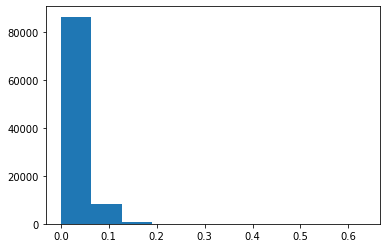

In [14]:
import matplotlib.pyplot as plt
plt.hist(test_pred)

In [12]:
# tn, fp, fn, tp 
confusion_matrix(test_pred_label,test_true).ravel()

array([92427,  3151,     2,     0])

In [15]:
# select single pro 
from collections import defaultdict

pros_keys = defaultdict(list)
for i,key in enumerate(test_keys_pro):
    pros_keys[key.split('/')[-1].split('_')[0]].append(i)
pros = set([pro.split('/')[-1].split('_')[0] for pro in test_keys_pro])

In [16]:
EFs = []
hits_lists = []
for pro in pros:
    idxs = pros_keys[pro]
    single_pro_true = test_true[idxs]
    single_pro_pred = test_pred[idxs]
    EF = []
    hits_list = []
    action_rate = sum(single_pro_true)/len(idxs)
    for rate in [0.001,0.005,0.01,0.05]:
        find_limit = int(len(idxs)*rate)
        # print(find_limit)
        _,indices = torch.sort(torch.tensor(single_pro_pred),descending = True)
        hits = np.sum(single_pro_true[indices[:find_limit]])
        EF.append((hits/find_limit)/action_rate)
        hits_list.append(hits)
    EFs.append(EF)
    hits_lists.append(hits_list)

/home/caoduanhua/anaconda3/envs/rdkit-env/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in long_scalars
  from ipykernel import kernelapp as app


In [17]:
EFs

[[0.0, 0.0, 2.7387387387387383, 1.0954954954954954],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 2.755244755244755, 2.0547588005215123],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.5337719298245615],
 [0.0, 5.136752136752136, 2.568376068376068, 3.082051282051282],
 [0.0, 0.0, 0.0, 0.5058333333333334],
 [0.0, 0.0, 0.0, 2.0],
 [0.0, 0.0, 0.0, 0.5012295081967214],
 [0.0, 0.0, 2.5876068376068373, 2.5876068376068373],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 2.0229508196721313],
 [0.0, 0.0, 2.5145833333333334, 2.5145833333333334],
 [nan, 0.0, 0.0, 0.0],
 [0.0, 0.0, 2.5909090909090913, 2.0],
 [0.0, 0.0, 0.0, 0.5067796610169492],
 [nan, 0.0, 0.0, 1.6543990799309947],
 [0.0, 0.0, 0.0, 1.0033898305084745],
 [0.0, 5.1625000000000005, 2.5812500000000003, 1.0155737704918035],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 0.5061475409836066],
 [30.624999999999996,
  5.104166666666666,
  5.104166666666666,
  2.0081967213114753],
 [0.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.6272134203168687],
 [0.0

In [49]:
# actions = sum()
EF = []
hits_list = []
action_rate = sum(test_true)/len(test_keys_pro)
for rate in [0.001,0.005,0.01,0.05]:
    find_limit = int(len(test_keys_pro)*rate)
    # print(find_limit)
    _,indices = torch.sort(torch.tensor(test_pred),descending = True)
    hits = np.sum(test_true[indices[:find_limit]])
    EF.append((hits/find_limit)/action_rate)
    hits_list.append(hits)

In [50]:
EF

[0.31929713207168986,
 1.2718334401178424,
 0.9528762580149907,
 0.9838146620120597]

'/home/caoduanhua/score_function/data/independent/dekois_pocket/ace2_decoy_glide_SP_481'